# Import Statements

In [ ]:
#!pip install category_encoders # for TargetEncoder

In [ ]:
#!pip install shap

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from category_encoders import TargetEncoder

# To enable plotting graphs in Jupyter notebook
%matplotlib inline

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

def csv_drive_path_generator(url):
 '''
 Help in read csv file directly from google drive.
 Make sure the csv format is standard.
 url:str - path to csv file example:
   url = 'https://drive.google.com/file/d/126JPZ3lYwdLyJ2d_7jxM9jMtZaOlF-Ld/view?usp=sharing'
 return : str
 '''
 path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
 return path

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preliminaries

The chosen dataset for the following ML Regression project is "Life Expectancy Data.csv" (source: https://www.kaggle.com/kumarajarshi/life-expectancy-who). 

This dataset contains information compiled by the World Health Organization (WHO) and the United Nations to track factors that affect life expectancy.

In a nutshell, this study will focus on immunization factors, mortality factors, economic factors, social factors and other health related factors as well.

- The data contains 2938 rows and 22 columns.
- Each row is a combination of a Country and a Year.
- 2 String columns (country and developing status)
- 20 numeric columns 

Columns - Features (independent variables):

1. Country: There are 193 unique countries.
2. Year: 2000-2015
3. Status: "Developed" (17% of the data) or "Developing" (83% of the data) status 
4. Adult Mortality: Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
5. Infant deaths: Number of Infant Deaths per 1000 population
6. Alcohol: Alcohol consumption per capita (15+) (in litres of pure alcohol)
7. Percentage expenditure: Country’s expenditure on health - as a percentage of Gross Domestic Product (GDP) per capita(%)
8. Total expenditure: General government expenditure on health as a percentage of total government expenditure (%)
9. BMI: Average Body Mass Index of entire population
10. Hepatitis B: (HepB) immunization coverage among 1-year-olds (%)
11. Polio: (Pol3) immunization coverage among 1-year-olds (%) 
12. Diphtheria: (DTP3) immunization coverage among 1-year-olds (%)
13. Measles: number of reported cases per 1000 population
14. Under-five deaths: Number of deaths under 5-years-old per 1000 population
15. HIV/AIDS: Deaths per 1 000 live births HIV/AIDS (0-4 years)
16. GDP: Gross Domestic Product per capita (in USD)
17. Population: Population of the country
18. Thinness 10-19 years: Prevalence of thinness among children and adolescents for Age 10 to 19 (%) 
19. Thinness 5-9 years: Prevalence of thinness among children for Age 5 to 9 (%)
20. Income composition of resources: Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
21. Schooling: Number of years of Schooling (years)

Target variable (The dependent variable - the one that we are going to predict):
- Life expectancy (in age)

# Read the data

In [ ]:
#path = csv_drive_path_generator('https://drive.google.com/file/d/1U6PyyZmNP6kK73LFBJpLmhsmLC1Hk_Eu/view?usp=sharing')
path = 'Life Expectancy Data.csv'
life_df = pd.read_csv(path)
life_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
print(f"The data frame has {life_df.shape[0]} rows and {life_df.shape[1]} columns.")

The data frame has 2938 rows and 22 columns.


## Data inspection

#### General info

Let's have a general glance at our data.

pandas.DataFrame.info method gives us information regarding index, dtype and columns, non-null values and memory usage.

In [ ]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

- We can see many of the columns have **missing values** in them.
- We can also see that some of the column names have **spaces** in them.
So first, we fix column names by stripping the spaces.
We also fix a **typo** in column name 'thinness  1-19 years'.
It should be: 'thinness 10-19 years'.

## Clean & Fix column names

In [ ]:
life_df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [ ]:
life_df.columns = life_df.columns.map(lambda col: col.strip())
life_df.rename(columns={'thinness  1-19 years':'thinness 10-19 years'}, inplace=True)
life_df.columns

Index(['Year', 'Status', 'Life expectancy', 'Adult Mortality', 'infant deaths',
       'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI',
       'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria',
       'HIV/AIDS', 'GDP', 'Population', 'thinness 10-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Country Encoded'],
      dtype='object')

## Handling missing values

In [ ]:
life_df.isnull().sum().sort_values(ascending=False)

Population                         652
Hepatitis B                        553
GDP                                448
Total expenditure                  226
Alcohol                            194
Income composition of resources    167
Schooling                          163
BMI                                 34
thinness 10-19 years                34
thinness 5-9 years                  34
Diphtheria                          19
Polio                               19
Adult Mortality                     10
Life expectancy                     10
under-five deaths                    0
HIV/AIDS                             0
Measles                              0
percentage expenditure               0
infant deaths                        0
Status                               0
Year                                 0
Country                              0
dtype: int64

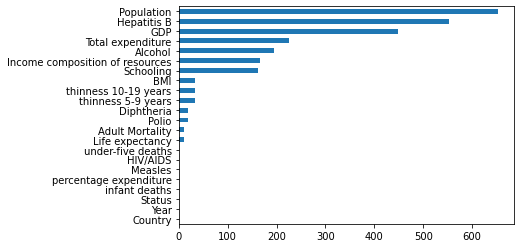

In [ ]:
life_df.isnull().sum().sort_values().plot.barh();

Removing rows where target column is NA - total 10 rows:

In [ ]:
life_df.dropna(subset=['Life expectancy'], how = 'all',inplace=True)
life_df.shape

(2928, 22)

Handling NAs for other columns: in this step of the project we just fill NA values with median values, and after the feature selection step we might consider to take care of the relevant features more wisely.

In [ ]:
# Option 1: dropping rows with missing values
# life_df.dropna(inplace=True)
# life_df.shape # output: (1649, 22) (dropped ~44% of the rows)

In [ ]:
# Option 2: fill NA values
columns_with_null_values = ['Life expectancy', 'Adult Mortality', 'Alcohol', 
                            'Hepatitis B', 'BMI', 'Polio', 'Total expenditure', 
                            'Diphtheria', 'GDP', 'Population', 'thinness 10-19 years',
                            'thinness 5-9 years', 'Income composition of resources', 'Schooling']

for col in columns_with_null_values:
  median_col = life_df[col].median()
  life_df[col].fillna(median_col, inplace=True)

life_df.shape

(2928, 22)

#### Number of distinct values for each column

In [ ]:
life_df.nunique()

Country                             183
Year                                 16
Status                                2
Life expectancy                     362
Adult Mortality                     425
infant deaths                       209
Alcohol                            1076
percentage expenditure             2323
Hepatitis B                          87
Measles                             958
BMI                                 603
under-five deaths                   252
Polio                                73
Total expenditure                   816
Diphtheria                           81
HIV/AIDS                            200
GDP                                2485
Population                         2278
thinness 10-19 years                200
thinness 5-9 years                  207
Income composition of resources     625
Schooling                           173
dtype: int64

#### Describe for numeric columns

In [ ]:
life_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 10-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2928.00000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2.928000e+03,2928.000000,2928.000000,2928.000000,2928.000000
mean,2007.50000,69.224932,164.796448,30.407445,4.559167,740.321185,83.045765,2427.855874,38.291291,42.179303,82.616120,5.916257,82.390710,1.747712,6627.389707,1.026315e+07,4.833675,4.865232,0.630128,12.016052
std,4.61056,9.523867,124.292079,118.114450,3.920534,1990.930605,22.942047,11485.970937,19.857308,160.700547,23.355634,2.385963,23.645132,5.085542,13316.392534,5.411179e+07,4.399553,4.487535,0.205440,3.254407
min,2000.00000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2003.75000,63.100000,74.000000,0.000000,1.107500,4.853964,82.000000,0.000000,19.400000,0.000000,78.000000,4.370000,78.000000,0.100000,578.797095,4.181205e+05,1.600000,1.600000,0.504000,10.300000
50%,2007.50000,72.100000,144.000000,3.000000,3.770000,65.611455,92.000000,17.000000,43.350000,4.000000,93.000000,5.750000,93.000000,0.100000,1764.973870,1.391756e+06,3.300000,3.400000,0.677000,12.300000
75%,2011.25000,75.700000,228.000000,22.000000,7.400000,442.614322,96.000000,362.250000,56.100000,28.000000,97.000000,7.330000,97.000000,0.800000,4793.630903,4.592777e+06,7.100000,7.200000,0.773000,14.100000
max,2015.00000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,77.600000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


## Pandas Profiling Report

In [ ]:
#!pip install pandas-profiling==2.7.1

In [ ]:
# from pandas_profiling import ProfileReport
# prof = ProfileReport(life_df)
# prof.to_file(output_file='output.html')

### Report summary
- Missing cells - 2563 (4.0%)
- No duplicate rows
- Life expectancy: mean: 69.22, min: 36.3, max: 89.0


# Separating the dataset into 2 datasets according to 'Status' (Developing vs. Developed countries).

In [ ]:
developing_df = life_df[life_df['Status']=='Developing']
developed_df = life_df[life_df['Status']=='Developed']

developing_df.shape, developed_df.shape

((2416, 22), (512, 22))

In [ ]:
developing_df.drop(['Status'], axis=1, inplace=True)
developed_df.drop(['Status'], axis=1, inplace=True)

# Visualizations

### Target variable distribution

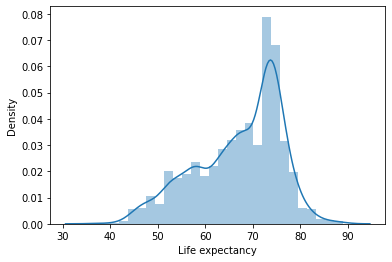

In [ ]:
sns.distplot(developing_df['Life expectancy'])
plt.show()

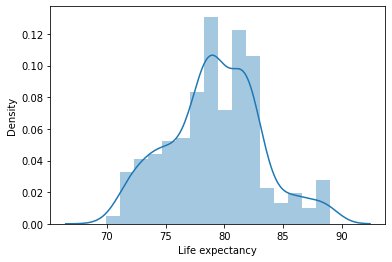

In [ ]:
sns.distplot(developed_df['Life expectancy'])
plt.show()

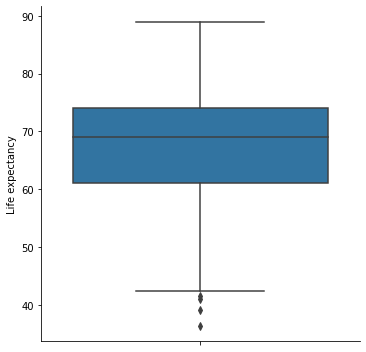

In [ ]:
sns.catplot(y="Life expectancy", kind="box", data=developing_df);

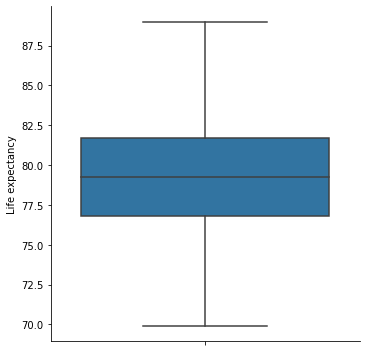

In [ ]:
sns.catplot(y="Life expectancy", kind="box", data=developed_df);

## Correlation with target variable

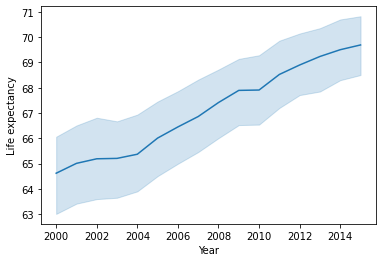

In [ ]:
sns.lineplot(x = 'Year', y = 'Life expectancy', data = developing_df)
plt.show()

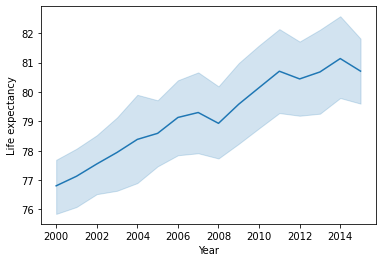

In [ ]:
sns.lineplot(x = 'Year', y = 'Life expectancy', data = developed_df)
plt.show()

# Data Preparation for the algorithms

## Categorical columns encoding

Models accept numbers only, so we apply the following Target Encoding. Regarding countries column - we have about 200 countries, 16 records per each country. The problem of target encoding is over-fitting. Indeed, relying on an average value isn’t always a good idea when the number of values used in the average is low. That's why we had an idea to combine countries into smaller groups, for example by demographic and socio-economic statuses, but since the absense of time we might try to do this later on.

In [ ]:
life_df['Status'] = life_df['Status'].replace({'Developing': 0, 'Developed': 1})
life_df['Status'].value_counts(normalize=True)

0    0.825137
1    0.174863
Name: Status, dtype: float64

In [ ]:
encoder = TargetEncoder()
life_df['Country Encoded'] = encoder.fit_transform(life_df['Country'], life_df['Life expectancy'])
developing_df['Country Encoded'] = encoder.fit_transform(developing_df['Country'], developing_df['Life expectancy'])
developed_df['Country Encoded'] = encoder.fit_transform(developed_df['Country'], developed_df['Life expectancy'])

In [ ]:
# We could also do it this way (almost exact same results):
# mean_encoding = life_df.groupby(['Country']).agg({'Life expectancy':['mean']}).reset_index()

# life_df = life_df.merge(mean_encoding, on='Country', how='left')

In [ ]:
life_df.drop(['Country'], axis=1, inplace=True)
developing_df.drop(['Country'], axis=1, inplace=True)
developed_df.drop(['Country'], axis=1, inplace=True)

# From now on we work only with 'developed_df' dataset

## Train-test split

In [ ]:
X_d = developed_df.drop('Life expectancy', axis=1)
y_d = developed_df['Life expectancy']

In [ ]:
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_d, y_d, train_size=0.75, random_state=1245)

# Linear Regression

### Scaling the data for Linear Regression

In [ ]:
scaler = StandardScaler()
X_d_train_scaled = scaler.fit_transform(X_d_train)
X_d_test_scaled = scaler.transform(X_d_test)

## Base model

In [ ]:
lm = LinearRegression()
lm.fit(X_d_train_scaled, y_d_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print("The developed model intercept is: {}".format(lm.intercept_))
print("The developed model coefficients are: {}".format(lm.coef_))

The developed model intercept is: 79.08671875000002
The developed model coefficients are: [ 1.28843629e+00  1.88223523e-01 -1.68404401e+00  6.43017180e-02
  2.25349283e-01  4.27096442e-02  1.13360453e-03 -6.33173359e-02
  1.82881931e+00 -1.07945124e-02 -1.93673111e-01  1.92001684e-01
  1.33226763e-15 -2.54322672e-01 -1.24453177e-01 -2.49976928e-01
  2.23942929e-01 -7.40340199e-02  2.23469551e-01  3.39181671e+00]


In [ ]:
y_d_train_pred = lm.predict(X_d_train_scaled)
rmse = mean_squared_error(y_d_train, y_d_train_pred)**0.5
print(f"Developed Train RMSE = {rmse:.2f}")

y_d_test_pred = lm.predict(X_d_test_scaled)
rmse = mean_squared_error(y_d_test, y_d_test_pred)**0.5
print(f"Developed Test RMSE = {rmse:.2f}")

Developed Train RMSE = 1.84
Developed Test RMSE = 2.04


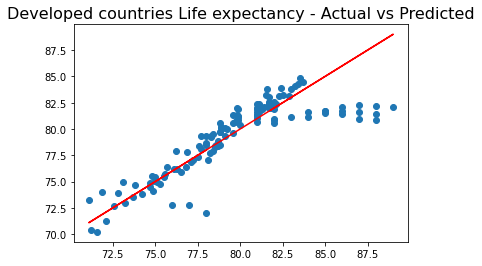

In [ ]:
plt.scatter(y_d_test, y_d_test_pred)
plt.plot(y_d_test, y_d_test, c='red')
plt.title('Developed countries Life expectancy - Actual vs Predicted', size=16)
plt.show()
# y = x , y_pred = y_actual

## Lasso regression - for feature selection

In [ ]:
regr = LassoCV(cv=5, random_state=101)
regr.fit(X_d_train_scaled, y_d_train)
print("LassoCV Best Alpha Scored: ", regr.alpha_)
print("LassoCV Model Accuracy: ", regr.score(X_d_test, y_d_test))
model_coef = pd.Series(regr.coef_, index = list(X_d.columns))
print("Variables Eliminated: ", str(sum(model_coef == 0)))
print("Variables Kept: ", str(sum(model_coef != 0)))

LassoCV Best Alpha Scored:  0.11340072606007265
LassoCV Model Accuracy:  -427682.11143408355
Variables Eliminated:  16
Variables Kept:  4


In [ ]:
model_coef.sort_values(ascending=False)

Country Encoded                    3.125951
Year                               1.133845
Schooling                          0.039451
Diphtheria                         0.026272
Income composition of resources    0.000000
BMI                               -0.000000
Adult Mortality                    0.000000
infant deaths                      0.000000
Alcohol                           -0.000000
percentage expenditure             0.000000
Hepatitis B                        0.000000
Measles                            0.000000
under-five deaths                  0.000000
thinness 5-9 years                -0.000000
Total expenditure                 -0.000000
HIV/AIDS                           0.000000
GDP                                0.000000
Population                        -0.000000
thinness 10-19 years              -0.000000
Polio                              0.000000
dtype: float64

Let's create a Feature Importance plot to understand which features have been considered most important by our model:

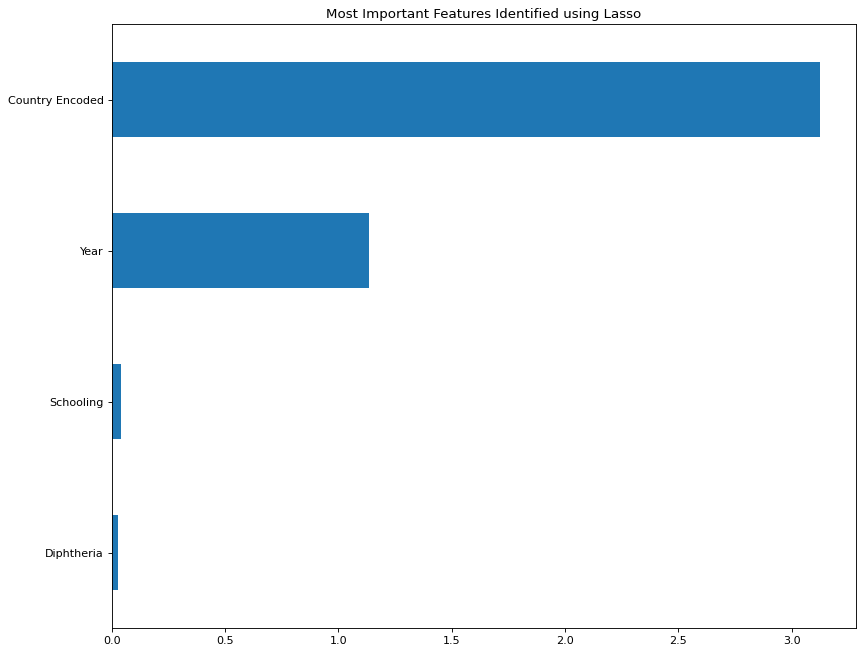

In [ ]:
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

top_coef = model_coef.sort_values()
top_coef[top_coef != 0].plot(kind = "barh")
plt.title("Most Important Features Identified using Lasso");

# Decision Tree

In [ ]:
model = DecisionTreeRegressor(max_leaf_nodes=10)
model.fit(X_d_train, y_d_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

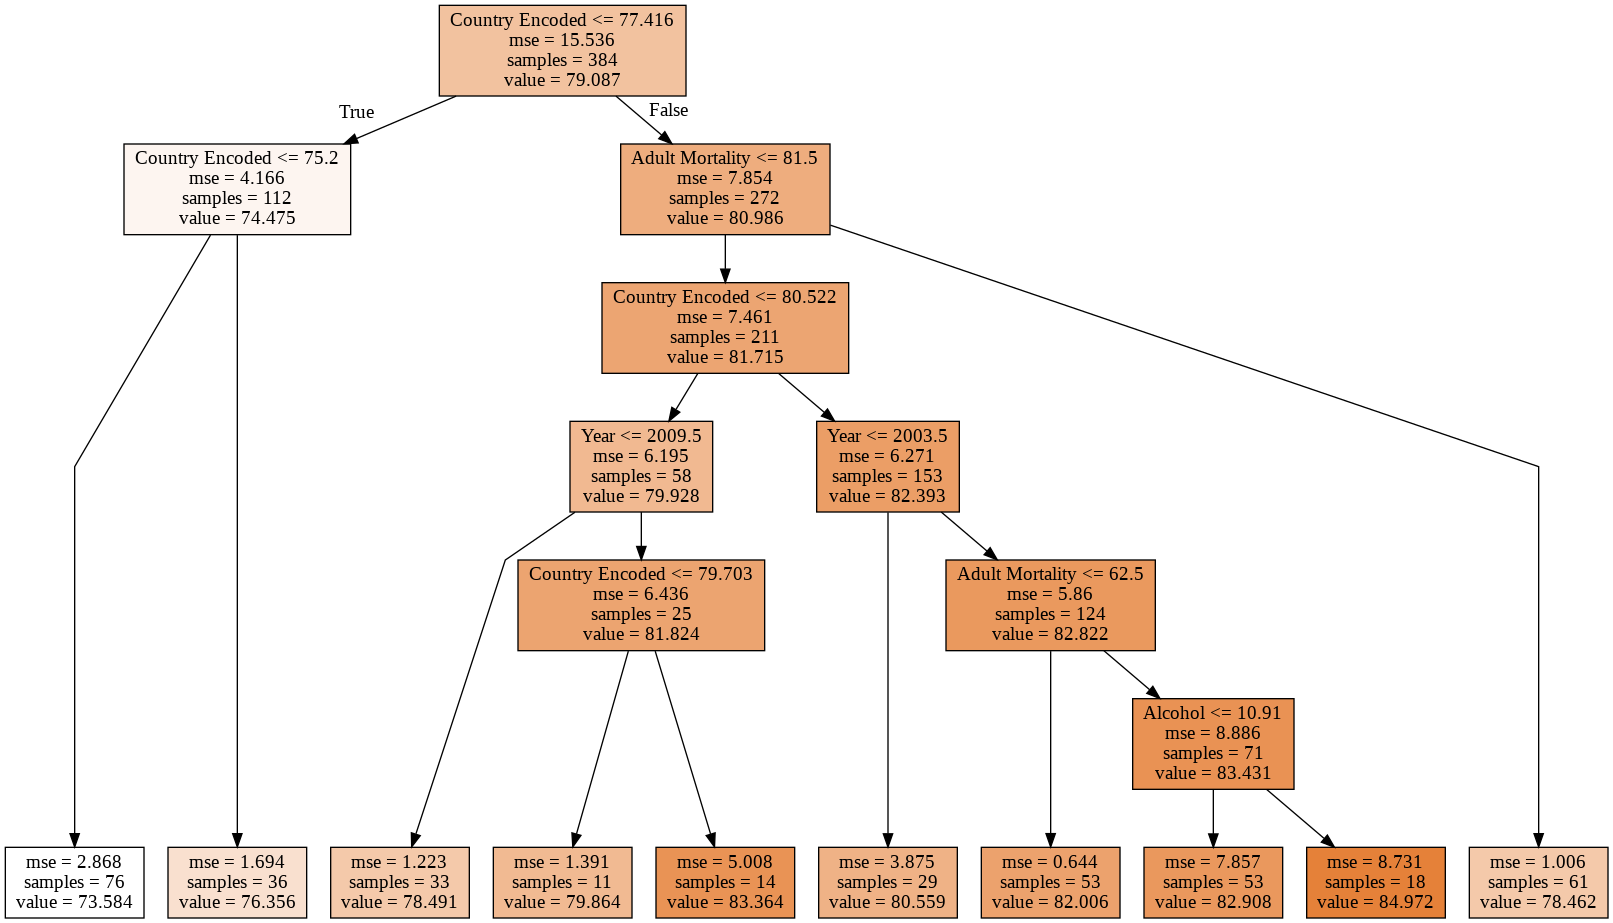

In [ ]:
dot_data = StringIO()  
export_graphviz(model, out_file=dot_data, feature_names=X_d.columns, leaves_parallel=True, filled=True, class_names=model.classes_)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=750)

In [ ]:
y_d_train_pred = model.predict(X_d_train)
rmse = mean_squared_error(y_d_train, y_d_train_pred)**0.5
print(f"Train RMSE = {rmse:.2f}")

y_d_test_pred = model.predict(X_d_test)
rmse = mean_squared_error(y_d_test, y_d_test_pred)**0.5
print(f"Test RMSE = {rmse:.2f}")

Train RMSE = 1.76
Test RMSE = 2.17


In [ ]:
for feature, importance in zip(X_d_train.columns, model.feature_importances_):
    print(f'{feature:12}: {round(importance,2)}')

Year        : 0.06
Adult Mortality: 0.12
infant deaths: 0.0
Alcohol     : 0.01
percentage expenditure: 0.0
Hepatitis B : 0.0
Measles     : 0.0
BMI         : 0.0
under-five deaths: 0.0
Polio       : 0.0
Total expenditure: 0.0
Diphtheria  : 0.0
HIV/AIDS    : 0.0
GDP         : 0.0
Population  : 0.0
thinness 10-19 years: 0.0
thinness 5-9 years: 0.0
Income composition of resources: 0.0
Schooling   : 0.0
Country Encoded: 0.81


According to DT model, the **most important features** are: **Country Encoded (0.81), Adult Mortality (0.12), Year (0.06) and Alcohol (0.01)** . We can try to run a model using the only features that were found as most important by Lasso and DT models.

# K-Nearest Neighbors

Let's try to run KNN model with different number of neighbors (between 1 to 25) and compare the results.

In [ ]:
rmse_dict = {}
train_rmse_list = []
test_rmse_list = []

for n_neighbors in range(1,26):
  knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)
  knn_model.fit(X_d_train, y_d_train)

  y_d_train_pred = knn_model.predict(X_d_train)
  train_rmse = mean_squared_error(y_d_train, y_d_train_pred)**0.5

  y_d_test_pred = knn_model.predict(X_d_test)
  test_rmse = mean_squared_error(y_d_test, y_d_test_pred)**0.5

  train_rmse = round(train_rmse,3)
  test_rmse = round(test_rmse,3)
  rmse_dict[n_neighbors] = [train_rmse, test_rmse]

  train_rmse_list.append(train_rmse)
  test_rmse_list.append(test_rmse)

print(f'Min Test RMSE: {min(test_rmse_list)}')
rmse_dict

Min Test RMSE: 3.201


{1: [0.0, 4.64],
 2: [1.892, 3.534],
 3: [2.273, 3.359],
 4: [2.509, 3.266],
 5: [2.734, 3.201],
 6: [2.854, 3.253],
 7: [2.927, 3.317],
 8: [3.036, 3.379],
 9: [3.075, 3.36],
 10: [3.116, 3.365],
 11: [3.14, 3.337],
 12: [3.165, 3.379],
 13: [3.206, 3.418],
 14: [3.245, 3.447],
 15: [3.278, 3.449],
 16: [3.293, 3.417],
 17: [3.314, 3.398],
 18: [3.351, 3.386],
 19: [3.375, 3.423],
 20: [3.42, 3.45],
 21: [3.448, 3.474],
 22: [3.468, 3.514],
 23: [3.478, 3.543],
 24: [3.496, 3.566],
 25: [3.518, 3.581]}

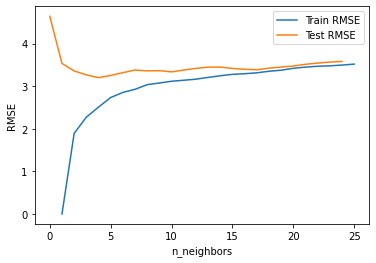

In [ ]:
list_n_neighbors = list(range(1,26))
plt.plot(list_n_neighbors, train_rmse_list, test_rmse_list);
plt.xlabel("n_neighbors");
plt.ylabel("RMSE");
plt.legend(labels=['Train RMSE', 'Test RMSE']);

 - We can see that the lowest Test RMSE is when **n_neighbors=5.
  (Train RMSE: 2.73 and Test RMSE 3.20)**.
 - We can also see that in this case, the model performed not as well as the other models. 

# Grid Search (5-Fold cross-validation)

In [ ]:
param_grid = {'max_depth': [3, 7, 12], 'min_samples_leaf': [5, 15, 40], 
              'min_samples_split': [5, 10]} # 'max_leaf_nodes': [5,8]

In [ ]:
gs_cv = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid, cv=5)

gs_cv.fit(X_d_train, y_d_train)

df_results_train = pd.DataFrame(gs_cv.cv_results_)[['param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_score']]

df_results_train

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_score
0,3,5,5,0.663182
1,3,5,10,0.663182
2,3,15,5,0.661923
3,3,15,10,0.661923
4,3,40,5,0.702461
5,3,40,10,0.702461
6,7,5,5,0.709067
7,7,5,10,0.709052
8,7,15,5,0.694067
9,7,15,10,0.694067


In [ ]:
print("Train: Tuned Decision Tree Parameters: {}".format(gs_cv.best_params_))
print("Train: Best score is {:.3f}".format(gs_cv.best_score_))

scores_mean = df_results_train['mean_test_score'].mean()
scores_std = df_results_train['mean_test_score'].std()

print("Train: Mean {:.3f}, STD {:.3f}".format(scores_mean, scores_std))

Train: Tuned Decision Tree Parameters: {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 5}
Train: Best score is 0.709
Train: Mean 0.688, STD 0.018


In [ ]:
rf_model = RandomForestRegressor(n_estimators=700, max_depth=7, min_samples_leaf=5, min_samples_split=5) # n_estimators default is 100 (Changed from 10 to 100 in sklearn version 0.22.)

rf_model.fit(X_d_train, y_d_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_d_train_pred = rf_model.predict(X_d_train)
rmse = mean_squared_error(y_d_train, y_d_train_pred)**0.5
print(f"Train RMSE = {rmse:.2f}")

y_d_test_pred = rf_model.predict(X_d_test)
rmse = mean_squared_error(y_d_test, y_d_test_pred)**0.5
print(f"Test RMSE = {rmse:.2f}")

Train RMSE = 1.21
Test RMSE = 1.80


# SHAP values
SHAP (SHapley Additive exPlanations) is a **unified approach to explain the output of any machine learning model**. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations.

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d


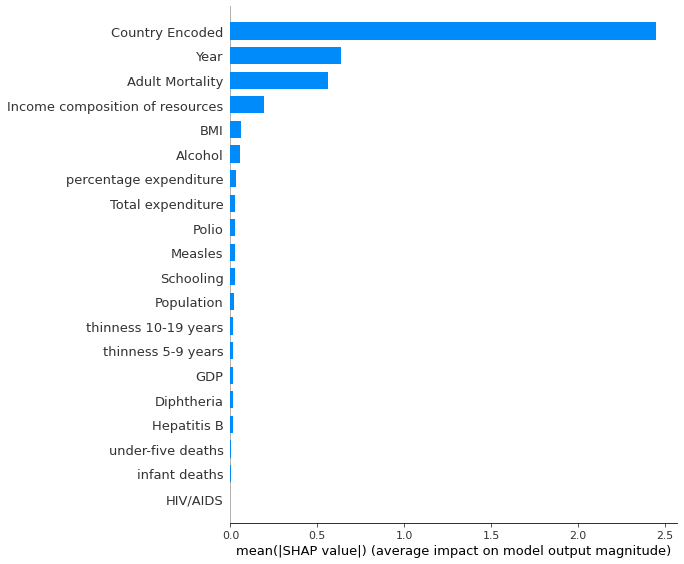

In [ ]:
import shap
shap_values = shap.TreeExplainer(rf_model).shap_values(X_d_train)
shap.summary_plot(shap_values, X_d_train, plot_type="bar")

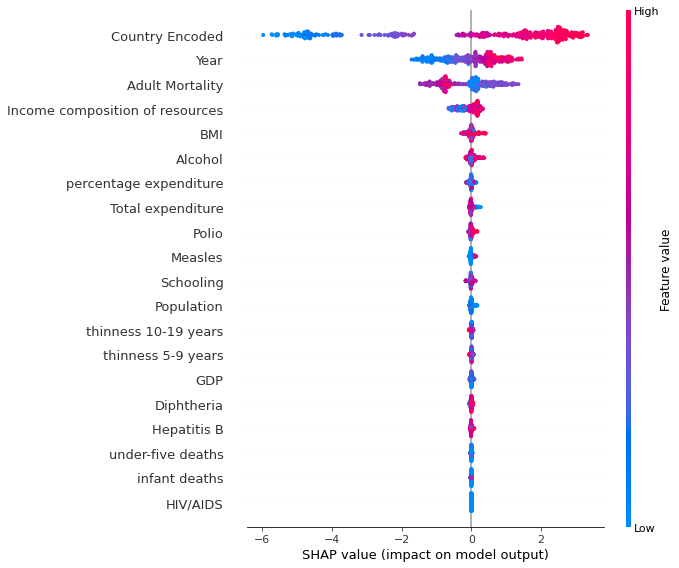

In [ ]:
fig = plt.figure()
shap.summary_plot(shap_values, X_d_train)
fig.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

# Comparison:
- Linear Regression: 
  - Train RMSE = 1.84
  - Test RMSE = 2.04
- Decision Tree:
  - Train RMSE = 1.76
  - Test RMSE = 2.17
- K-Nearest Neighbors: (n_neighbors = 5)
  - Train RMSE = 2.73
  - Test RMSE = 3.20
- Random Forest (after Grid Search):
  - Train RMSE = 1.21
  - Test RMSE = 1.80